In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install tensorboardX yacs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 34.1 MB/s 


In [ ]:
import os.path as osp
import sys
from datetime import datetime

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)

path_dir = '/content/drive/MyDrive/Colab Notebooks/Spine Detection/'
this_dir = sys.path[0]

lib_path = osp.join(this_dir, (path_dir + 'lib'))
add_path(lib_path)
print(sys.path)

['/content/drive/MyDrive/Colab Notebooks/Spine Detection/lib', '/content/drive/MyDrive/Colab Notebooks/hourglass network/lib', '/content/drive/MyDrive/Colab Notebooks/hourglass network/8927/lib', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']


In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter

from config import cfg
from config import update_config
from core.loss import JointsMSELoss
from core.function import validate
from utils.utils import save_checkpoint
from utils.utils import create_logger
from utils.utils import get_model_summary

import models


## Set input image size

256x192: res50_256x192_d256x3_adam_lr1e-3.yaml

384x288: res50_384x288_d256x3_adam_lr1e-3.yaml



In [ ]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

args = Namespace(
    cfg = (path_dir +  '/res50_384x288_d256x3_adam_lr1e-3.yaml'),
    modelDir = '',
    logDir = '',
    dataDir = '',
    opts = ''
)  




update_config(cfg, args)

In [ ]:
model = eval('models.pose_resnet.get_pose_net')(
        cfg, is_train=False
    )
model.final_layer = nn.Conv2d(256, 5, kernel_size=(1, 1), stride=(1, 1))
model = torch.nn.DataParallel(model).cuda()

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/checkpoint_2021-05-22T14_46_51.668717.pth')

model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
from utils.transforms import get_affine_transform

class ImageLoader():
    def __init__(self, img_path, box):
        self.path = img_path
        self.pixel_std = [200,200]
        self.image_size = [288, 384]
        self.aspect_ratio = self.image_size[0] * 1.0 / self.image_size[1]
        self.box = box
    
    def load(self):
        self.img = cv2.imread(self.path)
        self.center, self.scale = self.box2cs(self.box)
        
        trans = get_affine_transform(self.center[0], self.scale[0], 0, self.image_size)
        reshape_img = cv2.warpAffine(
            self.img,
            trans,
            (int(self.image_size[0]), int(self.image_size[1])),
            flags=cv2.INTER_LINEAR)
        self.reshape_img = reshape_img
    
    def get_tensor(self):
        inp = np.zeros([1,3,self.image_size[1], self.image_size[0]])
        _b, _g, _r = self.reshape_img[:,:,0], self.reshape_img[:,:,1], self.reshape_img[:,:,2]
        inp[0,0,:,:] = _r/255
        inp[0,1,:,:] = _g/255
        inp[0,2,:,:] = _b/255
        inp_tensor = torch.tensor(inp, dtype=torch.float32)
        
        return inp_tensor
    
    def box2cs(self, box):
        x, y, w, h = box[:4]
        return self.xywh2cs(x, y, w, h)
    
    def xywh2cs(self, x, y, w, h):
        center = np.zeros((2), dtype=np.float32)
        center[0] = x + w * 0.5
        center[1] = y + h * 0.5

        if w > self.aspect_ratio * h:
            h = w * 1.0 / self.aspect_ratio
        elif w < self.aspect_ratio * h:
            w = h * self.aspect_ratio
        scale = np.array(
            [w * 1.0 / self.pixel_std[0], h * 1.0 / self.pixel_std[1]],
            dtype=np.float32)
        if center[0] != -1:
            scale = scale * 1.25
        
        center = center.reshape([1, 2])
        scale = scale.reshape([1, 2])

        return center, scale  

In [ ]:
import cv2 
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt

In [ ]:
def load_image(img_path):

  img = cv2.imread(img_path)
  print(img.shape)
  box = np.array([0,0,img.shape[1], img.shape[0]])
  img = ImageLoader(img_path, box)
  img.load()
  plt.imshow(cv2.cvtColor(img.reshape_img,cv2.COLOR_BGR2RGB))
  plt.show()
  
  return img

(2048, 1536, 3)


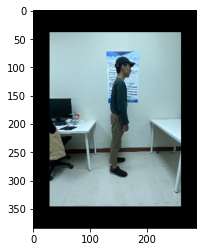

[[ 768. 1024.]]
[[ 9.599999 12.799999]]


In [ ]:
name = "104.jpg"
img_path = "/content/" + name

img = load_image(img_path)

print(img.center)
print(img.scale)

In [ ]:
inp_tensor = img.get_tensor()
inp_tensor = inp_tensor.cuda()
out_tensor = model(inp_tensor)
print(out_tensor.shape)

torch.Size([1, 5, 96, 72])


In [ ]:
heatmap_list = out_tensor.cpu().detach().numpy()
print(heatmap_list.shape)

(1, 5, 96, 72)


In [ ]:
from core.inference import get_final_preds
center, scale = img.center, img.scale
ans, score = get_final_preds(heatmap_list, center, scale)

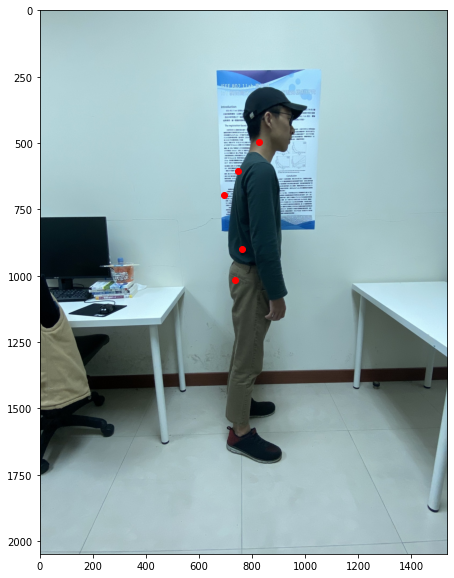

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img.img,cv2.COLOR_BGR2RGB))
plt.plot(ans[0][:,0], ans[0][:,1], 'ro')
plt.show()